In [2]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *

#Interactive graph modules
# %matplotlib notebook
from ipywidgets import *

In [3]:
#Configure simulation paratmers
#Geometric Parameters
r_max = 10 # maximum radial distance of simulation (m)
n = 200 #surface discretisation
g = 1.62 # gravitational constant

#Time parameters
t_count = 100 #number of timesteps
update_freq = t_count/10
t_max = 0.1
t = np.linspace(0, t_max, t_count) #time vector

In [4]:
#Set exhast gas parameters (fuel mixture estimate)
R = 8.314/0.028 #[J/mol·K] universal gas constant, normalized by molar mass
gamma = 1.4 # heat capacity ratio
mu_c = 17.49E-6 #[Pa.s] #viscosity in the rocket chamber

In [5]:
#Configure the surface geology parameters
D = (109) *1e-6 #diameter of dust particles (microns)
c = 0.6 #packing concentration in dust layer
sigma = 2500 #[kg/m3]density of dust particle

A_coh = 0 #cohesional shear stress (experimental)
tau_coh = 0 #cohesional shear stress (experimental)
alpha = (20)*np.pi/180 #static angle of repose of cohensionless particles (deg)
alpha_collapse = (25)*np.pi/180 #angle of repose at which avalanche start (deg)

K = 1 # shear stress augmentation factor

In [6]:
#Set rocket engine parameters
r_e = 0.005 #[m] nozzle radius exit
M_e = 5 #nozzle exit mach number
p_c = (1.25E6) #[Pa] rocket chamber pressure (max pressure)
T_c = 300 #[K] #temperature in the rocket chamber
h = 0.1 #[m] nozzle height above surface

In [23]:
r_oneway = np.linspace(-r_max, r_max, n) #
x,z = np.meshgrid(r_oneway, r_oneway)
grid_spacing = abs(x[0,0]-x[0,1])
# dr = r[1] - r[0]

y = np.zeros(shape=(n,n, len(t))) #surface elevation vector
print(y[1,10,0])
dy_dt = np.zeros(shape=(n,n, len(t))) #mass flow rate vector
tau = np.zeros(shape=(n,n, len(t))) #surface shear

c_x = 0 # Nozzle x coordinate
c_y = h # Nozzle y coordinate
c_z = 0 # Nozzle z coordinate
nozzle_vec = np.array([c_x,c_y,c_z])

theta = np.zeros(shape=(n,n))
beta = np.zeros(shape=(n,n))

In [24]:
print(y.shape)

(600, 600, 30)


In [14]:
def moving_average(array_var, n_pt=3):
    ret = np.cumsum(array_var, dtype=float)
    ret[n_pt:] = ret[n_pt:] - ret[:-n_pt]
    return ret[n_pt - 1:] / n_pt

In [17]:
def find_adjacent_indices(px, pz, dx, dz, n):
    """
    Find the next and previous grid indices along a vector.

    :param px: x-coordinate of the given point on the grid
    :param pz: z-coordinate of the given point on the grid
    :param dx: x-component of the vector direction
    :param dz: z-component of the vector direction
    :param grid_spacing: The spacing between grid points
    :return: Coordinates of the next and previous grid points along the vector
    """

    # Normalize the vector direction
    vec_length = np.sqrt(dx**2 + dz**2)
    dx_normalized = dx / vec_length
    dz_normalized = dz / vec_length

    # Calculate the next point along the vector
    next_point_x = px + dx_normalized #* grid_spacing
    next_point_z = pz + dz_normalized #* grid_spacing
    
    # Round to the nearest grid point using integer division
    next_index_x = int(ceiling(next_point_x))
    next_index_z = int(ceiling(next_point_z))
    
    # Calculate the previous point along the vector
    prev_point_x = px - dx_normalized #* grid_spacing
    prev_point_z = pz - dz_normalized #* grid_spacing
    
    # Round to the nearest grid point using integer division
    prev_index_x = int(floor(prev_point_x))
    prev_index_z = int(floor(prev_point_z))

    # Edge Cases
    if px == n-1:
        next_index_x = px
    elif px == 0:
        prev_index_x = px
    if pz == n-1:
        next_index_z = pz
    elif pz == 0:
        prev_index_z = pz

    return (next_index_x, next_index_z), (prev_index_x, prev_index_z)

In [19]:
# ini_pos = downrange[0]
def simulate():    
    #Loop through simulation time
    for i in range(1, len(t)):
        if i <= int(len(t)/2):
            nozzle_vec[0] -= 0.1 
        for k in range(n):
            for l in range(n):
                curr_pnt = np.array([x[k,l],y[k,l,i],z[k,l]])
                proj_nozzle = np.array([nozzle_vec[0],0,nozzle_vec[2]])
                nozzle_to_point = nozzle_vec - curr_pnt
                radius_vector = proj_nozzle - curr_pnt
                theta[k,l] = np.arccos((np.dot(nozzle_to_point,radius_vector))/np.linalg.norm(nozzle_to_point)/np.linalg.norm(radius_vector))
                next_idx, prev_idx = find_adjacent_indices(k,l,radius_vector[0],radius_vector[2],n)
                uphill_pnt = np.array([x[next_idx[0],next_idx[1]],y[next_idx[0],next_idx[1],i],z[next_idx[0],next_idx[1]]])
                downhill_pnt = np.array([x[prev_idx[0],prev_idx[1]],y[prev_idx[0],prev_idx[1],i],z[prev_idx[0],prev_idx[1]]])
                slope_vec = uphill_pnt - downhill_pnt
                dy = np.linalg.norm(slope_vec)
                dr = np.linalg.norm(radius_vector)
                # beta[k,l] = np.arccos(np.dot(radius_vector,slope_vec)/np.linalg.norm(radius_vector)/np.linalg.norm(slope_vec))
                beta = np.arctan(dy/dr)
                           
        #Calculate derived values
        k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
        p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
        p_s = np.minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
        p = p_s*np.cos(theta)**(k+4)*np.cos(beta)**2*(1-np.tan(theta)*np.tan(beta))**2 #ground pressure
        u = np.sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
        q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
        rho = 2*q/(np.square(u)) #density
        mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

        #Reynolds Numbers
        Re_D = rho*u*D/mu #particle Reynold number
        # Re_theta = rho*u*r/mu #surface Reynold number

        #Fluid Coefficents
        C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
        C_f = 0.84 #friction coefficient of surface

        #Calculated derived values continued
        tau[:,:,i] = K*C_f*q #surface shear
        tau_star = sigma*c*D*g*(np.cos(beta)*np.tan(alpha) - np.sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
        Xi = 18*mu_c*h/(sigma*D**2*np.sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*np.sqrt(2)*mu_c*np.sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
        a = 1/(0.5 + np.sqrt( 0.25 + (1/Xi) )) #momentum factor

        #Calculate erosion rate
        dy_dt[:,:,i] = 2*(tau[:,:,i]-tau_star)/(a*u*sigma*c*np.cos(beta)) # erosion rate
        dy_dt[:,:,i] = np.nan_to_num(dy_dt[:,:,i])

        #Apply errosion
        y[:,:,i] = y[:,:,i-1]-dy_dt[:,:,i]*(t[i]-t[i-1]) #surface modification due to erosion, forward euler scheme
        y[0,0,i] = y[1,1,i] #correcting for zero erosion at centerline.

        # if True:
        #     y_minslope = y[:,i]
        #     beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/(r_max/n))
        #     beta_minslope = np.insert(beta, 0, 0)
        #     while max(abs(beta_minslope)) > alpha_collapse:
        #         for k in range(len(y_minslope)-1):
        #             local_slope = np.arctan(y_minslope[k+1]-y_minslope[k])/(r_max/n)
        #             if abs(local_slope)>alpha_collapse:
        #                 mid_point = (y_minslope[k+1] + y_minslope[k])/2
        #                 y_minslope[k] = mid_point - np.sign(local_slope)*alpha*(0.5*r_max/n);
        #                 y_minslope[k+1] = mid_point + np.sign(local_slope)*alpha*(0.5*r_max/n);
        #         beta_minslope = np.arctan(np.diff(np.transpose(y_minslope))/(r_max/n))
        #         beta_minslope = np.insert(beta_minslope, 0, 0)
        #     y[:,i] = y_minslope
        # else:
        #     #Simple 3-point filtering
        #     y_filt = moving_average(np.concatenate((np.flip(y[:,i]), y[:,i])))
        #     y[:,i] = np.flip(y_filt[0:n])

        #Print time update
        if (i%update_freq ==0):
            print(str(i)+' of '+str(len(t)))
    
    #Return the erosion history
    return y

In [25]:
y = np.zeros(shape=(n,n, len(t))) #surface elevation vector
y_sim = simulate()

3 of 30
6 of 30
9 of 30
12 of 30
15 of 30
18 of 30
21 of 30
24 of 30
27 of 30


C:\Users\ishaa\AppData\Local\Temp\ipykernel_5228\147641007.py:13: RuntimeWarning: invalid value encountered in arccos
  theta[k,l] = np.arccos((np.dot(nozzle_to_point,radius_vector))/np.linalg.norm(nozzle_to_point)/np.linalg.norm(radius_vector))
C:\Users\ishaa\AppData\Local\Temp\ipykernel_5228\147641007.py:30: RuntimeWarning: invalid value encountered in divide
  rho = 2*q/(np.square(u)) #density


In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.animation as ani

mpl.rcParams['animation.ffmpeg_path'] = r"C:\Users\ishaa\Downloads\ffmpeg-master-latest-win64-gpl-shared\ffmpeg-master-latest-win64-gpl-shared\bin\ffmpeg.exe"

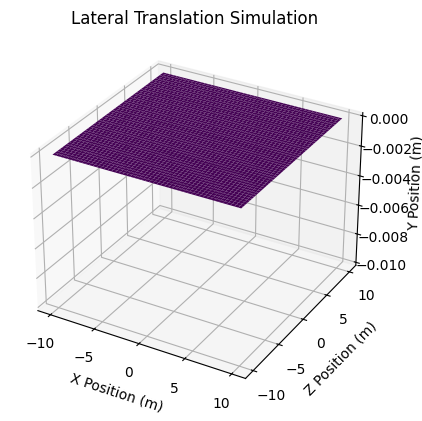

In [ ]:
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-0.01,0)
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Z Position (m)")
ax.set_zlabel("Y Position (m)")
plt.title("Lateral Translation Simulation")

# Initialize the plot with the first time step
surf = ax.plot_surface(x,z, y_sim[:, :, 0], cmap='viridis')

# Update function for the animation
def update(frame):
    ax.cla()  # Clear the previous plot
    ax.set_zlim3d(-0.01,0)
    ax.set_xlabel("X Position (m)")
    ax.set_ylabel("Z Position (m)")
    ax.set_zlabel("Y Position (m)")
    plt.title("Lateral Translation Simulation")
    surf = ax.plot_surface(x,z, y_sim[:, :, frame], cmap='viridis')
    return surf

# Create the animation
animation = FuncAnimation(fig, update, frames=len(t), interval=50, blit=False)
f = r"Animations/crater-3D-divert.mp4" 
writervideo = ani.FFMpegWriter(fps=25) 
animation.save(f, writer=writervideo)

Text(0.5, 0.92, 'Lateral Translation Simulation - Post Crater')

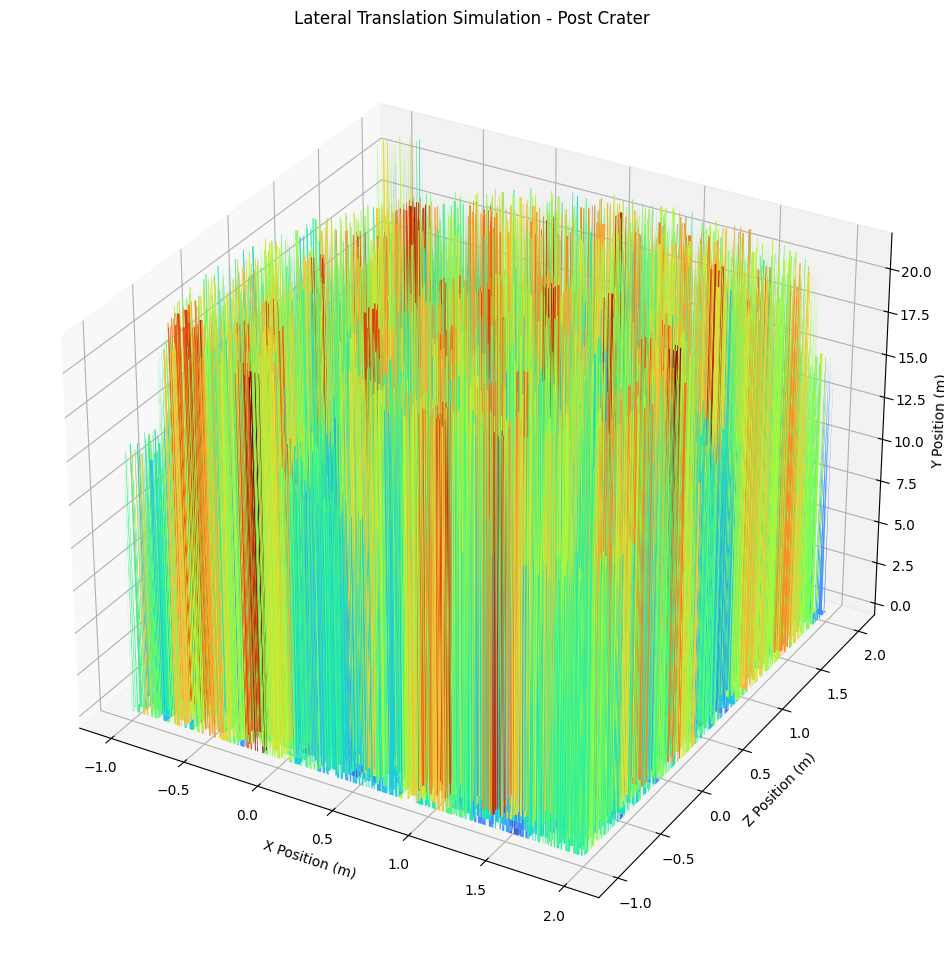

In [29]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,z, y_sim[:,:, -1], cmap="turbo")
# ax.set_zlim3d(-0.01,0)
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Z Position (m)")
ax.set_zlabel("Y Position (m)")
plt.title("Lateral Translation Simulation - Post Crater")